In [42]:
import os
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dotenv import load_dotenv
# from IPython.display import clear_output
# from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# , KFold
# from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from qiskit.circuit.library import zz_feature_map
# , real_amplitudes, efficient_su2, n_local
from qiskit import generate_preset_pass_manager

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

# from qiskit_machine_learning.optimizers import COBYLA
# from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [3]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 12345

In [5]:
phone = pd.read_csv('data/cleaned/cleaned_data.csv')

In [7]:
phone

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1994,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1995,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1996,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


# Le SVC avec un noyau quantique

Après avoir crée des modèles classiques, il est apparu que le plus performant est le SVC. Ce dernier a son équivalent en informatique quantique et c'est sur cet algorithme que nous allons nous concentrer sur cette partie.

L'algorithme SVC en informatique quantique fonctionne de manière similaire à son homologue classique, l'élément qui les différencie est l'utilisation d'un noyau quantique. Afin d'établir le modèle nous allons nous aider de la bibliothèque `qiskit-machine-learning`. Commençons par discuter des données.

## Travail des données

### Filtrage des données

Il ne va pas être possible d'utiliser l'intégralité des données pour entraîner le modèle quantique. Nous allons nous concentrer sur les données les plus corrélées afin de limiter le nombre d'attributs sur lequels nous voulons construire le modèle. La raison principale est que nous voulons utiliser le minimum de qubits possible afin de limiter les erreurs dans le circuit.

Nous avons vu dans l'analyse de données que les données les plus corrélées étaient `ram` et `battery_power`.

In [9]:
data = phone[['ram', 'battery_power', 'price_range', 'px_height', 'px_width']].copy()
data['nb_of_px'] = data['px_height'] * data['px_width']
data = data.drop(columns=['px_height', 'px_width'])
data

,ram,battery_power,price_range,nb_of_px
0,2549,842,1,15120
1,2631,1021,2,1799140
2,2603,563,2,2167308
3,2769,615,2,2171776
4,1411,1821,1,1464096
...,...,...,...,...
1993,668,794,0,2309580
1994,2032,1965,2,1797975
1995,3057,1911,3,1416576
1996,869,1512,0,225120


### Normalisation des données

En informatique quantique, il est préférable de normaliser les données avant de les utiliser pour entraîner un modèle. Nous allons faire une normalisation Min-Max pour commencer.

In [11]:
X = data.drop(columns=['price_range'])
y = data['price_range']

X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

On récupère le nombre d'attributs utilisés pour l'entraînement du modèle.

In [13]:
feature_dimension = X.shape[1]

On sépare les données d'entraînement et les données de test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)

Nous allons maintenant créer notre premier modèle quantique.quantique

## Création du noyau quantique

Le SVM est un algorithme d'apprentissage supervisé utilisé pour la classification en apprentissage supervisé classique. 

Son principal objectif est de trouver des hyperplans pour séparer les points qui auront au préalable été projetés dans un espace de plus grande dimension. Pour réaliser cette projection, nous allons utiliser un noyau dont le but va être de cartographier les points d'entrée dans l'espace de plus grande dimension, où il sera peut-être plus simple de résoudre le problème initial. Mathématiquement le noyau prend la forme suivante.

$k(\vec{x_{i}}, \vec{x_{j}}) = \langle f(\vec{x_{i}}) \lvert f(\vec{x_{j}}) \rangle$

- $k$ est le **noyau de fonction**
- $\vec{x_{i}}$, $\vec{x_{j}}$ sont des entrées à $n$ dimensions
- $f$ est une **fonction d'application** d'un espace de dimension $n$ vers un espace de dimension $m$
- $\langle a \lvert b \rangle$ représente le produit scalaire

In [17]:
load_dotenv('local.env')

token = os.getenv('IBM_TOKEN')
instance = os.getenv('IBM_INSTANCE')

QiskitRuntimeService.save_account(
    token=token,
    instance=instance,
    set_as_default=True,
    overwrite=True
)

service = QiskitRuntimeService()
backend = service.backend("ibm_torino")

# Défintion d'un simulateur qui a les mêmes propriétés que l'ordinateur quantique
fake_backend = AerSimulator.from_backend(backend)

In [18]:
sampler = Sampler(mode=fake_backend)

In [19]:
feature_map = zz_feature_map(feature_dimension=feature_dimension, reps=2, entanglement="linear")

In [23]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=0,
)

In [25]:
fidelity = ComputeUncompute(
    sampler=sampler,
    pass_manager=pass_manager
)

In [27]:
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [65]:
svc = SVC(kernel=quantum_kernel.evaluate)

svc.fit(X_train[:160], y_train[:160])

# score_callable_function = svc.score(X_test[:40], y_test[:40])

print(f"Callable kernel classification train score: {svc.score(X_train[:160], y_train[:160])}")
print(f"Callable kernel classification test score: {svc.score(X_test[:40], y_test[:40])}")

Callable kernel classification test score: 0.975
Callable kernel classification test score: 0.6


In [ ]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=quantum_kernel)

qsvc.fit(X_train, y_train)

qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

In [79]:
X_train.shape

(1598, 3)

In [81]:
X_test.shape

(400, 3)

In [29]:
nb_train_samples = 600
nb_test_samples = int(nb_train_samples * 100 / 80 - nb_train_samples)

limited_X_train = X_train[:nb_train_samples]
limited_y_train = y_train[:nb_train_samples]

In [31]:
limited_y_train.value_counts()

price_range
1    157
0    155
2    148
3    140
Name: count, dtype: int64

In [33]:
limited_X_test = X_test[:nb_test_samples]
limited_y_test = y_test[:nb_test_samples]

In [35]:
limited_y_test.value_counts()

price_range
3    45
2    36
1    35
0    34
Name: count, dtype: int64

In [37]:
start = time.time()

matrix_train = quantum_kernel.evaluate(x_vec=limited_X_train)
matrix_test = quantum_kernel.evaluate(x_vec=limited_X_test, y_vec=limited_X_train)

elapsed = time.time() - start

print(f"Temps d'entraînement: {round(elapsed)} secondes")

Temps d'entraînement: 4675 secondes


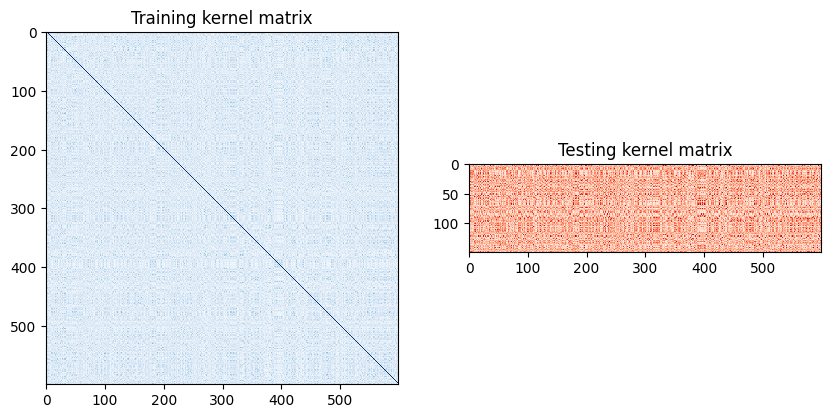

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

plt.show()

In [48]:
start = time.time()

precomputed_svc = SVC(kernel="precomputed")

precomputed_svc.fit(matrix_train, limited_y_train)

print(f"Callable kernel classification train score: {precomputed_svc.score(matrix_train, limited_y_train)}")
print(f"Callable kernel classification test score: {precomputed_svc.score(matrix_test, limited_y_test)}")

elapsed = time.time() - start

print(f"Temps d'entraînement: {round(elapsed)} secondes")

Callable kernel classification train score: 0.9683333333333334
Callable kernel classification test score: 0.6533333333333333
Temps d'entraînement: 0 secondes


In [37]:
# number of qubits is equal to the number of features
# num_qubits = 2

# number of steps performed during the training procedure
num_steps = 100

# regularization parameter
C = 1000

In [ ]:
from qiskit_machine_learning.algorithms import PegasosQSVC

pegasos_qsvc = PegasosQSVC(quantum_kernel=quantum_kernel, C=C, num_steps=num_steps)

# training
pegasos_qsvc.fit(X_train[:160], y_train[:160])

# testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

